# Task introduction
**Question answering** tasks involve the use of neural
networks to answer natural language questions
based on a given context, such as a paragraph or
document. Our goal is to find the best performing
model capable of performing these tasks

The dataset we used in our experiments is [CoQa](https://arxiv.org/abs/1808.07042) (Conversational Question Answering).

The models tested are:
*  [BERTTiny](https://huggingface.co/prajjwal1/bert-tiny)
*  [DistilRoBERTa](https://huggingface.co/distilroberta-base)

The metric to evaluate them is the [SQUAD-F1](https://github.com/allenai/allennlp-models/blob/main/allennlp_models/rc/tools/squad.py).

Members:
* Iulian Zorila &emsp; 0001033291
* Davide Brescia 0001036867
* Daniele Marini &nbsp;0001060063

# Install and Import

In [ ]:
!pip install transformers==4.25.1 # Due to issues on text generation with last update (4.26.0)
!pip install torchview
!pip install datasets
!pip install accelerate
!rm squad.py
!wget https://raw.githubusercontent.com/allenai/allennlp-models/main/allennlp_models/rc/tools/squad.py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 8.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 21

In [ ]:
import torch
import tensorflow as tf
from sklearn.model_selection import train_test_split
from datasets import Dataset, load_from_disk
import squad
from transformers import DataCollatorForSeq2Seq, EncoderDecoderModel
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, AutoTokenizer, PreTrainedTokenizerFast
from transformers import tokenization_utils_base, set_seed, trainer_utils
import datasets

import pandas as pd
from pandas.io.json import json_normalize
import numpy as np

from wordcloud import WordCloud, STOPWORDS
from torchview import draw_graph
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
plt.rcParams["figure.figsize"] = (15,6)

import urllib.request
import json
import pickle
import os
from tqdm import tqdm
import random

from typing import List, Callable, Dict, Tuple

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Manage dataset


In [ ]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.json')

    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [ ]:
# Training data
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path='coqa', url_path=train_url, suffix='train')

# Test data
test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path='coqa', url_path=test_url, suffix='test')

coqa-train-v1.0.json: 49.0MB [00:06, 8.05MB/s]                            


Download completed!


coqa-dev-v1.0.json: 9.09MB [00:01, 6.93MB/s]                            

Download completed!


In [ ]:
train=json.load((open('coqa/train.json')))['data']
test=json.load((open('coqa/test.json')))['data']

train_features=list(train[0].keys())
test_features=list(test[0].keys())

print("Training features:",train_features)
print("Test features:",test_features) # Ignore the 'additional_anwers' field
print("\nTotal samples:",len(train)+len(test), f"(Training: {len(train)} + Test: {len(test)})")

Training features: ['source', 'id', 'filename', 'story', 'questions', 'answers', 'name']
Test features: ['source', 'id', 'filename', 'story', 'questions', 'answers', 'additional_answers', 'name']

Total samples: 7699 (Training: 7199 + Test: 500)


## Dataset inspection

In [ ]:
#@title Show conversations { run: "auto", display-mode: "form" }
#@markdown Select a sample:
sample_idx = 51 #@param {type:"slider", min:0, max:100, step:1}
#@markdown Select the maximum number of turns:
turns_to_show = 5 #@param {type:"slider", min:1, max:36, step:1}

def show_conv(data:List[Dict[str,object]], sample_idx:int, limit:int=1000, story:bool=False):
  """
  Shows conversations along with additional information (e.g. story name, filename)

  :data: list of dictionaries in CoQa format
  :sample_idx: index of the sample to choose
  :limit: number of turns (question/answer) to show 
  :story: specifies if the story is shown or not

  """
  sample = data[sample_idx]
  
  # Print main info
  print(f"Story name: {sample['name']}  |  Filename: {sample['filename']}")
  print(f"Source: {sample['source']}  |  Total turns: {len(sample['questions'])}\n")
  if story: print(f"Story:\n\n{sample['story']}\n\n")

  # Print questions and answers
  i = 0
  for q,a in zip(sample["questions"],sample["answers"]):
    print(f"Q_{q['turn_id']}:",q["input_text"])
    print(f"A_{a['turn_id']}:",a["input_text"],"\n")
    i += 1
    if i >= limit: break

show_conv(train, sample_idx, turns_to_show)

Story name: data/gutenberg/txt/Harriet Elizabeth Beecher Stowe___Pink and White Tyranny.txt/CHAPTER XVIII_cbca4e3f54f9b983727b53674add089e6b1dfaf538e57ebd5b1f7ca  |  Filename: data/gutenberg/txt/Harriet Elizabeth Beecher Stowe___Pink and White Tyranny.txt/CHAPTER XVIII_cbca4e3f54f9b983727b53674add089e6b1dfaf538e57ebd5b1f7ca
Source: gutenberg  |  Total turns: 15

Q_1: How long had the snow been falling?
A_1: all night 

Q_2: Who's cottage was it?
A_2: Grace 

Q_3: Who use to her chamber door in the mornings?
A_3: John 

Q_4: What was it she said to herself?
A_4: "Positively," 

Q_5: what about after that?
A_5: I must invite some one to visit me. One wants a friend to help one enjoy solitude 



### Analysis of stories, questions and answers

Look at the number of words in each story, to get the average, the minimum and the maximum

Number of words in stories:

count    7199.00000
mean      271.44145
std        64.92706
min        70.00000
25%       245.00000
50%       267.00000
75%       294.00000
max      1030.00000
Name: story, dtype: float64 



<AxesSubplot:title={'center':'Number of words distribution in stories'}, ylabel='Frequency'>

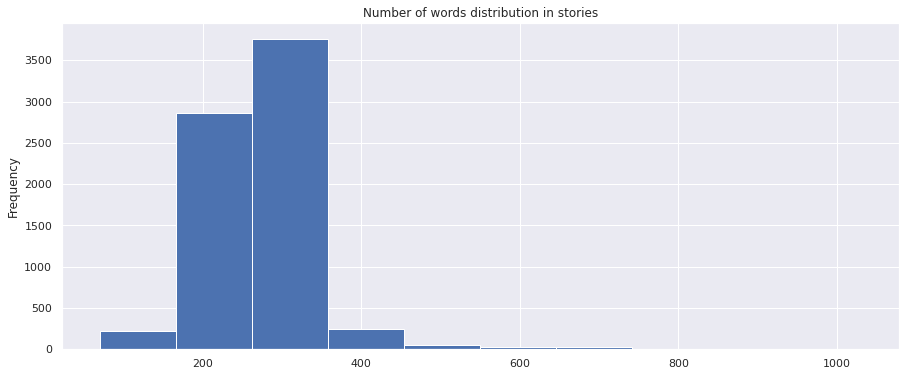

In [ ]:
print("Number of words in stories:\n")
stories_n_words = train_df['story'].apply(lambda s: len(s.split(' ')))
print(stories_n_words.describe(),"\n")

stories_n_words.plot.hist(title="Number of words distribution in stories")

Check the number of questions for each story

Number of questions:

count    7199.000000
mean       15.091957
std         5.175674
min         1.000000
25%        11.000000
50%        16.000000
75%        20.000000
max        36.000000
Name: questions, dtype: float64 



<AxesSubplot:title={'center':'Number of questions distribution'}, ylabel='Frequency'>

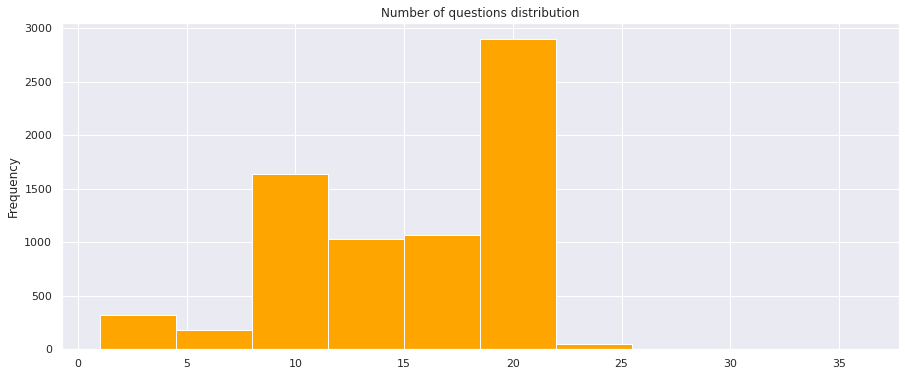

In [ ]:
print("Number of questions:\n")
n_questions = train_df['questions'].apply(len)
print(n_questions.describe(),"\n")
n_questions.plot.hist(title="Number of questions distribution", color='orange')

Get the expanded questions and answers

In [ ]:
print("Questions and answers:\n")
q_a = pd.concat([train_df['questions'].explode().apply(lambda q: q['input_text']),
                         train_df['answers'].explode().apply(lambda a: a['input_text'])], axis=1).reset_index(drop=True)
q_a

Questions and answers:



,questions,answers
0,When was the Vat formally opened?,It was formally established in 1475
1,what is the library for?,research
2,for what subjects?,"history, and law"
3,and?,"philosophy, science and theology"
4,what was started in 2014?,a project
...,...,...
108642,Who was a sub?,Xabi Alonso
108643,Was it his first game this year?,Yes
108644,What position did the team reach?,third
108645,Who was ahead of them?,Barca.


Check the average, the minimum and maximum number of words for questions and answers

In [ ]:
print("Number of questions/answers words:\n")
q_a_n_words = q_a.apply(lambda series: series.apply(lambda s: len(s.split(' '))) )
q_a_n_words.describe()

Number of questions/answers words:



,questions,answers
count,108647.000000,108647.000000
mean,5.461623,2.655481
std,2.474094,2.919474
min,1.000000,1.000000
25%,4.000000,1.000000
50%,5.000000,2.000000
75%,7.000000,3.000000
max,45.000000,353.000000


### Categories distribution
Check the distribution of each category for training and test set

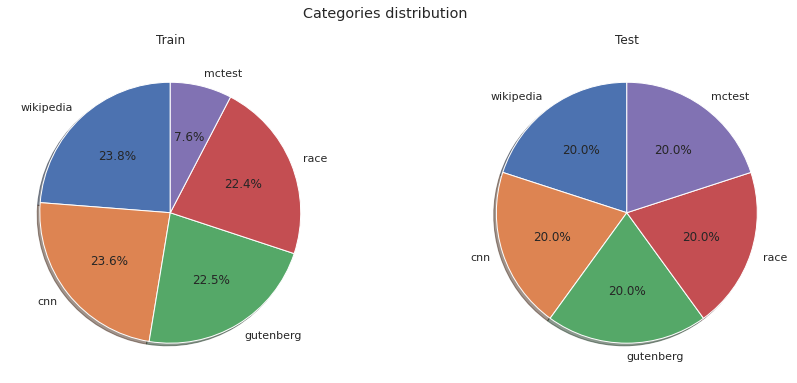

In [ ]:
# Get categories for train and test
categories = [{"Train":s["source"]} for s in train]
categories += [{"Test":s["source"]} for s in test]
categories_df = pd.DataFrame(categories)

# Plot pie charts for categories of train and test
data_type = ["Train","Test"]
labels = categories_df["Train"].dropna().unique()
fig, axs = plt.subplots(1,2)

for a,dt in zip(axs,data_type):
  # Calculate percentages
  sizes = (categories_df[dt].value_counts() / categories_df[dt].dropna().size * 100).to_numpy()
  a.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
  a.set_title(dt)

fig.suptitle("Categories distribution")
plt.show()

### Wordcloud
Show the wordcloud for stories belonging to the training and test set to check if there is any meaningful information among words

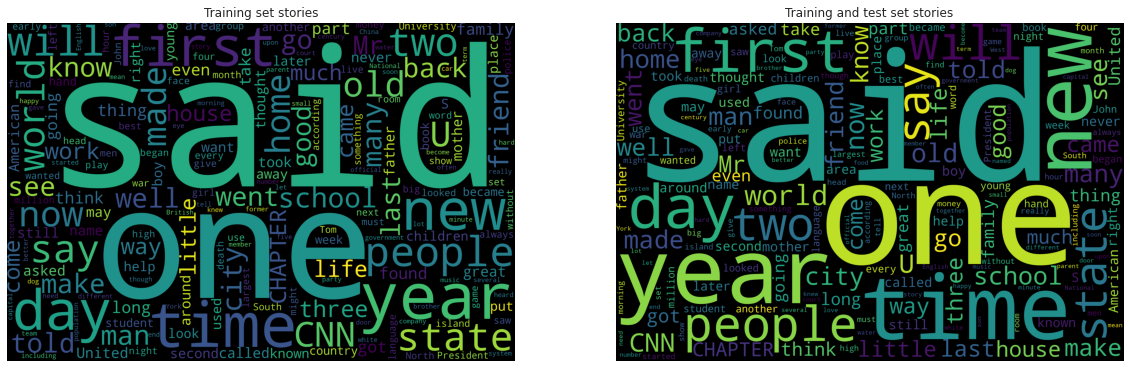

In [ ]:
# Compute wordcloud of training set
total_corpus = [s["story"] for s in train]
wc_train = WordCloud(width = 3000, height = 2000, collocations=False, stopwords = STOPWORDS).generate(" ".join(total_corpus))

# Compute wordcloud of training and test set
total_corpus += [s["story"] for s in test]
wc_train_test = WordCloud(width = 3000, height = 2000, collocations=False, stopwords = STOPWORDS).generate(" ".join(total_corpus))

# Plot results
fig, axs = plt.subplots(1,2, figsize=(20,11))
for a,wc,label in zip(axs,[wc_train, wc_train_test],["Training","Training and test"]):
  a.imshow(wc)
  a.set_title(label+" set stories")
  a.axis("off");
plt.show()

#Preprocessing
In this section we show all the operations applied on the dataset before feeding it to the model, to give an insight of how conversations, questions and answers are formatted after preprocessing.

Later in the notebook, all this work, will be carried out by the `Experiment` class.



## Dataframe creation

In [ ]:
def get_history(q_list:List[Dict[str,object]], a_list:List[Dict[str,object]], sep_token:str, start:int, end:int) -> str:
  """
  Gets the history, given the questions and the answers.

  :q_list: contains the dictionaries of questions
  :a_list: contains the dictionaries of answers
  :sep_token: specifies the separator character to divide conversations within a string
  :start: starting index of the slice inside q_list and a_list 
  :end: end index of the slice inside q_list and a_list 

  :return
    A string containing the history, where each conversation is separated by the sep_token
  """
  # Get the questions and answers inside the input_text field
  questions = list(map(lambda e: e["input_text"], q_list[start:end])) 
  answers = list(map(lambda e: e["input_text"], a_list[start:end]))
  
  # Unify question and answer in the lists with a white space
  q_and_a = list(map(lambda e: e[0].replace('\n',"") + " " + e[1].replace('\n',""), zip(questions,answers)))

  return sep_token.join(q_and_a)

def df_creation(coqa_list:List[Dict[str,object]], sep_token:str, max_history:int = 2) -> pd.DataFrame:
  '''
  Takes as input a list containing all the informations and creates a dataframe, removing the unanswarable questions

  :coqa_list: list of dictionaries in CoQa format
  :sep_token: specifies the separator needed to divide conversations inside the history 

  :return
    A dataframe containing containing 4 columns: story, question, history and answers
  '''

  data = {'source': [],'context': [],'questions': [],'answers': [], 'history': []}
  cnt_unk = 0

  # Iter through dataframe and for each row add the corresponding element in the dictionary
  for row in coqa_list:
    q, a = row['questions'], row['answers']
    q_list, a_list = [], []

    # Reset the max_history if there aren't enough conversations
    history_len = len(q) if len(q) < max_history else max_history 

    # The first max_history elements won't have the required previous conversations
    # e.g. 1st has no story, 2nd has just one conv, 3rd has just two and so on
    history = []
    for i in range(history_len):
      # Add to lists only if the question is answerable
      if a[i]['input_text'].replace('\n', '') != 'unknown':
        history.append(get_history(q, a, sep_token, 0, i))

    for i in range(len(q)):
      # Add to lists only if the question is answerable
      if a[i]['input_text'].replace('\n', '') != 'unknown':
        
        # Previous max_history elements have been alreay processed
        if i >= history_len:
          history.append(get_history(q, a, sep_token, i-history_len, i))

        q_list.append(q[i]['input_text'].replace('\n', ''))
        a_list.append(a[i]['input_text'].replace('\n', ''))
      else: cnt_unk += 1

    # Append only if there are answers
    if a_list != []:
      data['questions'].append(q_list)
      data['answers'].append(a_list)
      data['history'].append(history)
      data['context'].append(row['story'].replace('\n', ''))
      data['source'].append(row['source'])

  print(f"Removed {cnt_unk} unanswarable questions")

  return pd.DataFrame(data)

def load_and_create_df(sep_token:str="[SEP]", max_history:int=2):
  """
  Loads CoQa dataset json and creates the dataframes
  """
  dataset = {'train':None,'test':None}

  for k in dataset:
    # Load json
    coqa_list = json.load((open(f'coqa/{k}.json')))['data']
    # Create dataframe
    dataset[k] = df_creation(coqa_list, sep_token, max_history)

  return dataset.values()

Here we define:
*  The tokenizer, which specifies the separator `[SEP]` to process the history needed for following questions.
*  `max_history` which specifies how many previous questions and answers should be kept for following questions.



In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
max_history = 3

train_df = df_creation(train, tokenizer.sep_token, max_history)
test_df = df_creation(test, tokenizer.sep_token, max_history)

print(f"\nTrain shape: {train_df.shape}, Turns: {len(train_df['answers'].explode())}")
print(f"Test shape: {test_df.shape}, Turns: {len(test_df['answers'].explode())}")

Removed 1371 unanswarable questions
Removed 66 unanswarable questions

Train shape: (7193, 5), Turns: 107276
Test shape: (500, 5), Turns: 7917


Check if the history was correctly added

In [ ]:
n_questions = train_df["questions"].apply(len)
story_idx = 1

for n in range(1,max_history+1):
  print("\n","-"*100,"\n")
  print("max_history:",n,"  |  ","source:",train_df[n_questions == n].iloc[story_idx]["source"])
  print("\nQuestions:",train_df[n_questions == n]["questions"].iloc[story_idx])
  print("\nHistory:",train_df[n_questions == n]["history"].iloc[story_idx])


 ---------------------------------------------------------------------------------------------------- 

max_history: 1   |   source: cnn

Questions: ['What is the name of the movie?']

History: ['']

 ---------------------------------------------------------------------------------------------------- 

max_history: 2   |   source: mctest

Questions: ['who liked playing a cowboy?', 'what was he doing in his room?']

History: ['', 'who liked playing a cowboy? Bill']

 ---------------------------------------------------------------------------------------------------- 

max_history: 3   |   source: race

Questions: ['Where does the motivation to succeed come from?', 'What can the mind achieve?', 'Who  mentions that?']

History: ['', 'Where does the motivation to succeed come from? the burning desire to achieve a purpose', 'Where does the motivation to succeed come from? the burning desire to achieve a purpose[SEP]What can the mind achieve? whatever the mind of man can conceive and believ

## Test Train Validation split

#### The CoQA dataset contains only training and validation set, therefore the latter will be used as test, while the training set will be further splitted to obtain the validation.

The dataset is splitted at the "story" level, then it will be expanded to get to the "answers" level

In [ ]:
# Fix a specific random seed=42 for reproducibility
def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    set_seed(seed)

set_reproducibility(42)

# Train validation splitting
train_df, val_df = train_test_split(train_df, test_size=0.2)

print(f'Train data: {train_df.shape}')
print(f'Validation data: {val_df.shape}')
print(f'Test data: {test_df.shape}')

Train data: (5754, 5)
Validation data: (1439, 5)
Test data: (500, 5)


Now we have to expand the dataset at the "answers" level, hence the story (context) will be repeated for each question/answer pair

In [ ]:
def expand_dataset(dataset:List[pd.DataFrame]) -> List[pd.DataFrame]:
  """
  Expands the dataset at the answers level, i.e. for each question/answer the context is repeated
  
  :dataset: contains the dataframes representing the train, val and test

  :return
    Train, val and test dataframe expanded
  """
  for i in range(len(dataset)):
    d = dataset[i]

    # Reapeat story and source for each question
    expanded_stories, expanded_source = [], []

    for s,q,sr in zip(d['context'],d['questions'],d['source']):
      expanded_stories += [s]*len(q)
      expanded_source += [sr]*len(q)
    
    expanded_source = pd.Series(expanded_source,name='source')
    expanded_stories = pd.Series(expanded_stories,name='context')

    # Expand history, questions and answers
    expanded_hist = d['history'].explode().reset_index(drop=True)
    expanded_qs = d['questions'].explode().reset_index(drop=True)
    expanded_as = d['answers'].explode().reset_index(drop=True)

    dataset[i] = pd.concat([expanded_source,expanded_stories,expanded_qs,expanded_as,expanded_hist],axis=1)

  return dataset

In [ ]:
train_df,val_df,test_df = expand_dataset([train_df,val_df,test_df])

print(f"Train shape: {train_df.shape}  |  Val shape: {val_df.shape}  |  Test shape: {test_df.shape}\n\n")
train_df.head()

Train shape: (85806, 5)  |  Val shape: (21470, 5)  |  Test shape: (7917, 5)




,source,context,questions,answers,history
0,gutenberg,"CHAPTER V--""BLOODY AS THE HUNTER"" The lads lay...",Who scratched his head?,Dick,
1,gutenberg,"CHAPTER V--""BLOODY AS THE HUNTER"" The lads lay...",What is the chapter's name?,BLOODY AS THE HUNTER,Who scratched his head? Dick
2,gutenberg,"CHAPTER V--""BLOODY AS THE HUNTER"" The lads lay...",Who was he talking to?,Matcham,Who scratched his head? Dick[SEP]What is the c...
3,gutenberg,"CHAPTER V--""BLOODY AS THE HUNTER"" The lads lay...",Who spoke first?,Matcham,Who scratched his head? Dick[SEP]What is the c...
4,gutenberg,"CHAPTER V--""BLOODY AS THE HUNTER"" The lads lay...",What did he say?,"He said ""and now, forth to Holywood.""",What is the chapter's name? BLOODY AS THE HUNT...


# Experiments
Train bert-tiny and distilroberta-base with different seeds (2022, 1337 and 42), namely the experiments to be processed.

### Common functions
The following functions will be employed inside the `Experiment` class.

Split the training set to get the validation and expand the datasets at the answer level

In [ ]:
def split_expand(train_df:pd.DataFrame, 
                 test_df:pd.DataFrame,
                 val_size:float=0.2,
                 shuffle=True) -> List[pd.DataFrame]:
  """
  Splits the training set to get the validation set and expands the datasets
  
  :train_df: training set dataframe
  :test_df: test set dataframe
  :val_size: size of the validation set

  :return
    Expanded training, validation and test set dataframes
  """               

  train_df, val_df = train_df, val_df = train_test_split(train_df, test_size=val_size, shuffle=shuffle)
  train_df, val_df, test_df = expand_dataset([train_df,val_df,test_df])

  return [train_df, val_df, test_df]

Prepare the data to be given to the model by unifying the `story` with the `questions`

In [ ]:
def prepare_tokenize(batch:datasets.formatting.formatting.LazyBatch, 
                        tokenizer:PreTrainedTokenizerFast, 
                        history:bool) -> tokenization_utils_base.BatchEncoding:
    '''
    Unifies the context with the history, if :history: is True, then tokenizes the data for model fine-tuning

    :batch: input batch to process, containing context, history, questions and answers
    :tokenizer: specifies the tokenizer to use
    :history: specifies whether to include the history in the input or not

    :return
      A tokenized input batch
    '''

    # Concatanate history to the context (context[SEP]history)
    if history:
      batch['context'] = list(map(lambda e: tokenizer.sep_token.join(filter(None,e)), 
                                  zip(batch['context'],batch['history'])))
    
    # Tokenize questions and input
    model_inputs = tokenizer(batch['questions'],batch['context'], max_length=512, truncation=True)

    # Tokenize the answers (i.e. labels)
    labels = tokenizer(batch["answers"])
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs

Once the dataset has been tokenized, for the fine tuning process we need just the following columns:
*   `input_ids`
*   `attention_mask`
*   `labels`



In [ ]:
def remove_col(dataset:Dict[str, List]) -> Dict[str, List]:
  """
  Removes unnecessary columns from the input

  :dataset: dictionary containing all the columns

  :return
    The same dictionary with the removed columns
  """
  needed_cols=['input_ids','attention_mask','labels']

  for i in dataset.column_names:
    if i not in needed_cols:
      dataset=dataset.remove_columns(i)
  return dataset

To monitor the training of the model we need a metric to compute on the validation set, for this task we will use the **SQUAD-F1**

In [ ]:
# This kind of encapsulated definition allows to pass extra parameters to the compute_metrics function 
def compute_metrics(tokenizer:PreTrainedTokenizerFast):
  def evaluate(eval_pred:trainer_utils.EvalPrediction) -> Dict[str,np.float64]:
    '''
    Takes in input the prediction and the labels as single element and returns the SQUAD F1-score
    This function needs to be passed as parameter to the Seq2SeqTrainer

    :eval_pred: contains the prediction and the labels
    
    :return
      SQUAD F1-score
    '''

    # Obtain predictions and labels from the input
    predictions, labels = eval_pred

    # Decode the prediction and labels, to take the tokenized version and tranform it into a string
    pred_str = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id) # handle missing or padded values in the labels array
    label_str = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute F1 score
    f1_score = [squad.compute_f1(pred,label) for pred, label in zip(pred_str, label_str)]
    f1_score=np.mean(f1_score)

    return {'F1 score':f1_score}
  return evaluate

Get the number of trainable parameters in Pytorch module

In [ ]:
def get_n_params(model:torch.nn.Module) -> int:
  """
  Gets the number of trainable paramaters in the given model
  :return 
    Number of trainable parameters
  """
  tot_params = 0

  for p in model.parameters():
      p_layer = 1

      for s in p.size(): p_layer *= s
      tot_params += p_layer

  return tot_params

Plot the model structure as graph

In [ ]:
def plot_model(model:torch.nn.Module, 
               tokenized_input:tokenization_utils_base.BatchEncoding, 
               save_img=False):
  """
  Plots the model structure as a graph, given a properly tokenized input.
  """
  model_graph = draw_graph(model, input_data=tokenized_input, save_graph=save_img)
  model_graph.visual_graph  

### Experiment class setup

In [ ]:
class Experiment(object):
  """
  Support class to manage training and saving of different models along with their input data.
  """
  def __init__(self, 
               seed:int, 
               data:Dict[str,pd.DataFrame],
               model_name:str,
               tokenizer:PreTrainedTokenizerFast):
    
    super().__init__()

    self.seed = seed
    self.seed_folder = f"seed_{seed}"

    # Set reproducibility and split data
    set_reproducibility(seed)
    self.train_df, self.val_df, self.test_df = split_expand(data["train"],data["test"])

    self.model_name = model_name
    # Get rid of the slash character and what come before
    self.model_folder = model_name.split('/')[1] if model_name.__contains__('/') else model_name
    self.tokenizer = tokenizer

  def get_info(self):
    return {
              "seed":self.seed,
              "model_name":self.model_name,
              "tokenizer":self.tokenizer,
              "train_shape": self.train_df.shape,
              "val_shape": self.val_df.shape,
              "test_shape": self.test_df.shape,
            }

  def tokenize(self, history:bool) -> List[datasets.arrow_dataset.Dataset]:
    """
    Prepares the data for the tokenization step and proceeds to tokenize it
    
    :return 
      List containing the tokenized training, validation and test set
    """
    tokenized_datasets = []
    
    for df,label in zip((self.train_df, self.val_df, self.test_df),("Training set","Validation set", "Test set")):
      print(f"\nTokenizing {label} ...")
      # Convert to dataset object
      dataset = Dataset.from_pandas(df)
      # Tokenize
      tokenized_ds = dataset.map(lambda batch: prepare_tokenize(batch, self.tokenizer, history), batched=True)
      # Remove unnecessary columns
      tokenized_ds = remove_col(tokenized_ds)
      tokenized_datasets.append(tokenized_ds)

    return tokenized_datasets

  def create_model(self, device:str=None) -> EncoderDecoderModel:
    """
    Creates the model, according to the internal configuration
    """
    print("\nCreating model ...")
    # Define the model
    model = EncoderDecoderModel.from_encoder_decoder_pretrained(self.model_name, self.model_name)
    if device is not None: model.to(device)
    
    # Configurate
    model.config.decoder_start_token_id = self.tokenizer.cls_token_id
    model.config.cls_token_id = self.tokenizer.cls_token_id
    model.config.eos_token_id = self.tokenizer.sep_token_id 
    model.config.pad_token_id = self.tokenizer.pad_token_id
    model.config.vocab_size = model.config.decoder.vocab_size
    
    answers_len = [len(self.tokenizer(a)['input_ids']) for a in self.train_df['answers']]
    model.config.max_length = int(np.quantile(answers_len, 0.99))
    model.config.min_length = int(np.min(answers_len))

    model.config.no_repeat_ngram_size = 3
    model.config.early_stopping = True
    model.config.length_penalty = 2.0
    model.config.num_beams = 4

    if device is not None:
       print(f"\nModel is on {device}")
    else:
      is_on_cuda = {next(model.parameters()).is_cuda}
      print(f"Warning: device has not been specified, the model is on {'cuda' if is_on_cuda else 'cpu'}")

    print("\nTrainable parameters:")
    print(f"Encoder: {get_n_params(model.get_encoder()):,}")
    print(f"Decoder: {get_n_params(model.get_decoder()):,}")

    return model

  def create_trainer(self, model:EncoderDecoderModel, 
                     tokenized_train:datasets.arrow_dataset.Dataset, 
                     tokenized_val:datasets.arrow_dataset.Dataset) -> Seq2SeqTrainer:
    """
    Creates the trainer, according to the internal training arguments
    :model: must be an encoder/decoder
    :tokenized_train: contains the tokenized training set
    :tokenized_val: contains the tokenized validation set

    :return
      The trainer of the given model
    """
    
    # Smaller learning rate for distilroberta
    lr = 2e-4 if self.model_folder == 'bert-tiny' else 2e-5
    # Bigger batch size for distilroberta, since we used Colab's GPU premium to train it
    batch_size = 16 if self.model_folder == 'bert-tiny' else 64

    # Define training arguments
    training_args = Seq2SeqTrainingArguments(
        output_dir="./",
        evaluation_strategy="epoch",
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        auto_find_batch_size = True,
        num_train_epochs=3,
        weight_decay=0.01,
        predict_with_generate=True,
        fp16=True
    )

    # DataCollator necessary to dynamically pad the inputs
    data_collator = DataCollatorForSeq2Seq(self.tokenizer, model)

    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=self.tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics(self.tokenizer),
    ) 

    return trainer

  def save_dataframes(self, dir:str):
    """
    Saves the expanded dataframes (train,val,test) of the experiment
    """
    dir = os.path.join(dir, self.seed_folder, self.model_folder)
    datasets_names = ["train","val","test"]

    print("\nSaving dataframes ...")
    dataframes_path = os.path.join(dir,"dataframes")

    # Create directory if doesn't exists
    if not os.path.exists(dataframes_path): os.makedirs(dataframes_path)

    # Save dataframes
    for name,df in tqdm(zip(datasets_names,(self.train_df,self.val_df,self.test_df))):
      df.to_csv(os.path.join(dataframes_path, f"{name}.csv"), index=False)

    print("\nDone!")

  def save_tokenized_data(self, 
                dir:str,
                history:bool,
                tokenized_train:datasets.arrow_dataset.Dataset, 
                tokenized_val:datasets.arrow_dataset.Dataset, 
                tokenized_test:datasets.arrow_dataset.Dataset):

    dir = os.path.join(dir, self.seed_folder, self.model_folder, f"{'history' if history else 'no_history'}")

    datasets_names = ["train","val","test"]

    print("\nSaving tokenized data ...\n")
    tokenized_path = os.path.join(dir,"tokenized_data")
    
    # Create directory if doesn't exists
    if not os.path.exists(tokenized_path): os.makedirs(tokenized_path)
    
    # Save tokenized data
    for name,d in zip(datasets_names,(tokenized_train, tokenized_val, tokenized_test)):
      file_path = os.path.join(tokenized_path,f"{name}.hf")
      d.save_to_disk(file_path)
    
    print("\nDone!")

  def save_model(self, 
           dir:str, 
           model:EncoderDecoderModel, 
           history:bool):
    """
    Creates a folder if doesn't exist and saves it
    :dir: directory where the data will be saved
    :model: encoder/decoder model to save
    :history: represents whether the model has been trained with or without the history
    """

    dir = os.path.join(dir, self.seed_folder, self.model_folder, f"{'history' if history else 'no_history'}")

    # Create directory if doesn't exists
    if not os.path.exists(dir): os.makedirs(dir)

    file_name = f"{self.model_folder}_{'H' if history else 'noH'}_{self.seed}.pdh"
    dir = os.path.join(dir, file_name)
    torch.save(model, dir)  

### Data preparation
Create a `models` dictionary which contains the models names, their tokenizer and their data.

This dictionary will be used along all experiments

In [ ]:
max_history = 5
working_dir = "/content/drive/MyDrive/QA_Models"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"{'-'*10} max_history: {max_history}  |  working_dir: {working_dir}  |  device: {device} {'-'*10}")

models = {
    "bert-tiny":{"name":"prajjwal1/bert-tiny", "tokenizer":None, "data":None}, 
    "distilroberta":{"name":"distilroberta-base", "tokenizer":None, "data":None}
    }

for k,v in models.items():
  print("\n","-"*10,f"Setting up for {k}","-"*10)
  print("\n--> Getting tokenizer")
  v["tokenizer"] = AutoTokenizer.from_pretrained(v["name"], use_fast=True)

  print("\n--> Preparing data")
  print("\t Training set")

  train_df = df_creation(train, v["tokenizer"].sep_token, max_history)

  print("\t Test set")
  test_df = df_creation(test, v["tokenizer"].sep_token, max_history)
  v["data"] = {"train":train_df, "test":test_df}

---------- max_history: 5  |  working_dir: /content/drive/MyDrive/QA_Models  |  device: cpu ----------

 ---------- Setting up for bert-tiny ----------

--> Getting tokenizer



--> Preparing data
	 Training set
Removed 1371 unanswarable questions
	 Test set
Removed 66 unanswarable questions

 ---------- Setting up for distilroberta ----------

--> Getting tokenizer



--> Preparing data
	 Training set
Removed 1371 unanswarable questions
	 Test set
Removed 66 unanswarable questions


## Seed 1337

In [ ]:
seed = 1337

#### Bert-tiny

Create experiment

In [ ]:
m = models["bert-tiny"]
experiment = Experiment(seed, m["data"], m["name"], m["tokenizer"])
experiment.save_dataframes(working_dir)

print("\nExperiment information:\n")
experiment.get_info()


Saving dataframes ...


3it [00:18,  6.19s/it]


Done!

Experiment information:



{'seed': 1337,
 'model_name': 'prajjwal1/bert-tiny',
 'tokenizer': BertTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}),
 'train_shape': (85722, 5),
 'val_shape': (21554, 5),
 'test_shape': (7917, 5)}

In [ ]:
model = experiment.create_model()


Creating model ...


Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertLMHeadModel: ['cls.seq_re


Trainable parameters:
Encoder: 4,385,920
Decoder: 4,549,306


#####Without history

In [ ]:
history = False
tokenized_train, tokenized_val, tokenized_test = experiment.tokenize(history)
experiment.save_tokenized_data(working_dir, history, tokenized_train, tokenized_val, tokenized_test)


Tokenizing Training set ...


Map:   0%|          | 0/85722 [00:00<?, ? examples/s]


Tokenizing Validation set ...


Map:   0%|          | 0/21554 [00:00<?, ? examples/s]


Tokenizing Test set ...


Map:   0%|          | 0/7917 [00:00<?, ? examples/s]


Saving tokenized data ...



Saving the dataset (0/1 shards):   0%|          | 0/85722 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/21554 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7917 [00:00<?, ? examples/s]


Done!


In [ ]:
trainer = experiment.create_trainer(model, tokenized_train, tokenized_val)
trainer.train()


Creating trainer ...


Using cuda_amp half precision backend
/usr/local/lib/python3.8/dist-packages/accelerate/memory_utils.py:23: FutureWarning: memory_utils has been reorganized to utils.memory. Import `find_executable_batchsize` from the main `__init__`: `from accelerate import find_executable_batch_size` to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 85722
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 16074
  Number of trainable parameters = 8935226
You're using a BertTokenizerFast tokenizer. Please note that with a f

Epoch,Training Loss,Validation Loss,F1 score
1,3.613300,3.479316,0.150845
2,3.186700,3.377164,0.171932
3,2.911300,3.346284,0.182252


Saving model checkpoint to ./checkpoint-500
Configuration saved in ./checkpoint-500/config.json
Model weights saved in ./checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./checkpoint-500/tokenizer_config.json
Special tokens file saved in ./checkpoint-500/special_tokens_map.json
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
Saving model checkpoint to ./checkpoint-1000
Configuration saved in ./checkpoint-1000/config.json
Model weights saved in ./checkpoint-1000/pytorch_model.bin
tokeni


-------->DEBUG: Saving predictions



Saving model checkpoint to ./checkpoint-5500
Configuration saved in ./checkpoint-5500/config.json
Model weights saved in ./checkpoint-5500/pytorch_model.bin
tokenizer config file saved in ./checkpoint-5500/tokenizer_config.json
Special tokens file saved in ./checkpoint-5500/special_tokens_map.json
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
Saving model checkpoint to ./checkpoint-6000
Configuration saved in ./checkpoint-6000/config.json
Model weights saved in ./checkpoint-6000/pytorch_model.bin
t


-------->DEBUG: Saving predictions



Saving model checkpoint to ./checkpoint-11000
Configuration saved in ./checkpoint-11000/config.json
Model weights saved in ./checkpoint-11000/pytorch_model.bin
tokenizer config file saved in ./checkpoint-11000/tokenizer_config.json
Special tokens file saved in ./checkpoint-11000/special_tokens_map.json
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
Saving model checkpoint to ./checkpoint-11500
Configuration saved in ./checkpoint-11500/config.json
Model weights saved in ./checkpoint-11500/pytorch_mod


-------->DEBUG: Saving predictions





Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=16074, training_loss=3.3547871898059243, metrics={'train_runtime': 1333.489, 'train_samples_per_second': 192.852, 'train_steps_per_second': 12.054, 'total_flos': 726392960708520.0, 'train_loss': 3.3547871898059243, 'epoch': 3.0})

In [ ]:
experiment.save_model(working_dir, model, history)

#####With history

In [ ]:
history = True
tokenized_train, tokenized_val, tokenized_test = experiment.tokenize(history)
experiment.save_tokenized_data(working_dir, history, tokenized_train, tokenized_val, tokenized_test)


Tokenizing Training set ...


Map:   0%|          | 0/85722 [00:00<?, ? examples/s]


Tokenizing Validation set ...


Map:   0%|          | 0/21554 [00:00<?, ? examples/s]


Tokenizing Test set ...


Map:   0%|          | 0/7917 [00:00<?, ? examples/s]


Saving tokenized data ...



Saving the dataset (0/1 shards):   0%|          | 0/85722 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/21554 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7917 [00:00<?, ? examples/s]


Done!


In [ ]:
trainer = experiment.create_trainer(model, tokenized_train, tokenized_val)
trainer.train()


Creating trainer ...


Using cuda_amp half precision backend
/usr/local/lib/python3.8/dist-packages/accelerate/memory_utils.py:23: FutureWarning: memory_utils has been reorganized to utils.memory. Import `find_executable_batchsize` from the main `__init__`: `from accelerate import find_executable_batch_size` to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 85722
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 16074
  Number of trainable parameters = 8935226
You're using a BertTokenizerFast tokenizer. Please note that with a f

Epoch,Training Loss,Validation Loss,F1 score
1,3.611400,3.481193,0.149030
2,3.193200,3.372123,0.174082
3,2.919700,3.344395,0.184836


Saving model checkpoint to ./checkpoint-500
Configuration saved in ./checkpoint-500/config.json
Model weights saved in ./checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./checkpoint-500/tokenizer_config.json
Special tokens file saved in ./checkpoint-500/special_tokens_map.json
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
Saving model checkpoint to ./checkpoint-1000
Configuration saved in ./checkpoint-1000/config.json
Model weights saved in ./checkpoint-1000/pytorch_model.bin
tokeni


-------->DEBUG: Saving predictions



Saving model checkpoint to ./checkpoint-5500
Configuration saved in ./checkpoint-5500/config.json
Model weights saved in ./checkpoint-5500/pytorch_model.bin
tokenizer config file saved in ./checkpoint-5500/tokenizer_config.json
Special tokens file saved in ./checkpoint-5500/special_tokens_map.json
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
Saving model checkpoint to ./checkpoint-6000
Configuration saved in ./checkpoint-6000/config.json
Model weights saved in ./checkpoint-6000/pytorch_model.bin
t


-------->DEBUG: Saving predictions



Saving model checkpoint to ./checkpoint-11000
Configuration saved in ./checkpoint-11000/config.json
Model weights saved in ./checkpoint-11000/pytorch_model.bin
tokenizer config file saved in ./checkpoint-11000/tokenizer_config.json
Special tokens file saved in ./checkpoint-11000/special_tokens_map.json
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
Saving model checkpoint to ./checkpoint-11500
Configuration saved in ./checkpoint-11500/config.json
Model weights saved in ./checkpoint-11500/pytorch_mod


-------->DEBUG: Saving predictions





Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=16074, training_loss=3.3583803764249285, metrics={'train_runtime': 1359.9733, 'train_samples_per_second': 189.096, 'train_steps_per_second': 11.819, 'total_flos': 765975881091960.0, 'train_loss': 3.3583803764249285, 'epoch': 3.0})

In [ ]:
experiment.save_model(working_dir, model, history)

#### DistilRoberta

Create experiment

In [ ]:
m = models["distilroberta"]
experiment = Experiment(seed, m["data"], m["name"], m["tokenizer"])
experiment.save_dataframes(working_dir)

print("\nExperiment information\n")
experiment.get_info()


Saving dataframes ...


3it [00:12,  4.16s/it]


Done!

Experiment information



{'seed': 1337,
 'model_name': 'distilroberta-base',
 'tokenizer': RobertaTokenizerFast(name_or_path='distilroberta-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)}),
 'train_shape': (85722, 5),
 'val_shape': (21554, 5),
 'test_shape': (7917, 5)}

In [ ]:
model = experiment.create_model()


Creating model ...


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForCausalLM were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['roberta.encoder.layer.3.crossattention.self.key.bias', 'roberta.encoder.layer.2.crossattention.self.value.weight', 'roberta.encoder.layer.4.crossattention.out


Trainable parameters:
Encoder: 82,118,400
Decoder: 96,353,625


#####Without history

In [ ]:
history = False
tokenized_train, tokenized_val, tokenized_test = experiment.tokenize(history)
experiment.save_tokenized_data(working_dir, history, tokenized_train, tokenized_val, tokenized_test)


Tokenizing Training set ...


Map:   0%|          | 0/85722 [00:00<?, ? examples/s]


Tokenizing Validation set ...


Map:   0%|          | 0/21554 [00:00<?, ? examples/s]


Tokenizing Test set ...


Map:   0%|          | 0/7917 [00:00<?, ? examples/s]


Saving tokenized data ...



Saving the dataset (0/1 shards):   0%|          | 0/85722 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/21554 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7917 [00:00<?, ? examples/s]


Done!


In [ ]:
trainer = experiment.create_trainer(model, tokenized_train, tokenized_val)
trainer.train()

Using cuda_amp half precision backend
/usr/local/lib/python3.8/dist-packages/accelerate/memory_utils.py:23: FutureWarning: memory_utils has been reorganized to utils.memory. Import `find_executable_batchsize` from the main `__init__`: `from accelerate import find_executable_batch_size` to avoid this warning.
  warnings.warn(
***** Running training *****
  Num examples = 85722
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 4020
  Number of trainable parameters = 178472025
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduc

Epoch,Training Loss,Validation Loss,F1 score
1,3.805600,3.139509,0.165457
2,2.729300,2.436166,0.366007
3,2.165900,2.147865,0.447422


***** Running Evaluation *****
  Num examples = 21554
  Batch size = 64
Saving model checkpoint to trained_distilroberta-base/checkpoint-1340
Configuration saved in trained_distilroberta-base/checkpoint-1340/config.json
Model weights saved in trained_distilroberta-base/checkpoint-1340/pytorch_model.bin
tokenizer config file saved in trained_distilroberta-base/checkpoint-1340/tokenizer_config.json
Special tokens file saved in trained_distilroberta-base/checkpoint-1340/special_tokens_map.json
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.wa

TrainOutput(global_step=4020, training_loss=3.0812961113393604, metrics={'train_runtime': 3164.6561, 'train_samples_per_second': 81.262, 'train_steps_per_second': 1.27, 'total_flos': 7.937581836248064e+16, 'train_loss': 3.0812961113393604, 'epoch': 3.0})

In [ ]:
experiment.save_model(working_dir, model, history)

##### With history

In [ ]:
history = True
tokenized_train, tokenized_val, tokenized_test = experiment.tokenize(history)
experiment.save_tokenized_data(working_dir, history, tokenized_train, tokenized_val, tokenized_test)


Tokenizing Training set ...


Map:   0%|          | 0/85722 [00:00<?, ? examples/s]


Tokenizing Validation set ...


Map:   0%|          | 0/21554 [00:00<?, ? examples/s]


Tokenizing Test set ...


Map:   0%|          | 0/7917 [00:00<?, ? examples/s]


Saving tokenized data ...



Saving the dataset (0/1 shards):   0%|          | 0/85722 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/21554 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7917 [00:00<?, ? examples/s]


Done!


In [ ]:
trainer = experiment.create_trainer(model, tokenized_train, tokenized_val)
trainer.train()

Using cuda_amp half precision backend
/usr/local/lib/python3.8/dist-packages/accelerate/memory_utils.py:23: FutureWarning: memory_utils has been reorganized to utils.memory. Import `find_executable_batchsize` from the main `__init__`: `from accelerate import find_executable_batch_size` to avoid this warning.
  warnings.warn(
***** Running training *****
  Num examples = 85722
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 4020
  Number of trainable parameters = 178472025
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduc

Epoch,Training Loss,Validation Loss,F1 score
1,3.837800,3.114502,0.164583
2,2.611400,2.268143,0.406395
3,2.003600,1.960931,0.491794


***** Running Evaluation *****
  Num examples = 21554
  Batch size = 64
Saving model checkpoint to trained_distilroberta-base_with_history/checkpoint-1340
Configuration saved in trained_distilroberta-base_with_history/checkpoint-1340/config.json
Model weights saved in trained_distilroberta-base_with_history/checkpoint-1340/pytorch_model.bin
tokenizer config file saved in trained_distilroberta-base_with_history/checkpoint-1340/tokenizer_config.json
Special tokens file saved in trained_distilroberta-base_with_history/checkpoint-1340/special_tokens_map.json
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on

TrainOutput(global_step=4020, training_loss=3.0073667829902613, metrics={'train_runtime': 3192.2812, 'train_samples_per_second': 80.559, 'train_steps_per_second': 1.259, 'total_flos': 7.937581836248064e+16, 'train_loss': 3.0073667829902613, 'epoch': 3.0})

In [ ]:
experiment.save_model(working_dir, model, history)

## Seed 2022

In [ ]:
seed = 2022

#### Bert-tiny

Create experiment

In [ ]:
m = models["bert-tiny"]
experiment = Experiment(seed, m["data"], m["name"], m["tokenizer"])
experiment.save_dataframes(working_dir)

print("\nExperiment information:\n")
experiment.get_info()


Saving dataframes ...


3it [00:11,  4.00s/it]


Done!

Experiment information:



{'seed': 2022,
 'model_name': 'prajjwal1/bert-tiny',
 'tokenizer': PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}),
 'train_shape': (85685, 5),
 'val_shape': (21591, 5),
 'test_shape': (7917, 5)}

In [ ]:
model = experiment.create_model()


Creating model ...


Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertLMHeadModel: ['cls.seq_re


Trainable parameters:
Encoder: 4,385,920
Decoder: 4,549,306


#####Without history

In [ ]:
history = False
tokenized_train, tokenized_val, tokenized_test = experiment.tokenize(history)
experiment.save_tokenized_data(working_dir, history, tokenized_train, tokenized_val, tokenized_test)


Tokenizing Training set ...


Map:   0%|          | 0/85685 [00:00<?, ? examples/s]


Tokenizing Validation set ...


Map:   0%|          | 0/21591 [00:00<?, ? examples/s]


Tokenizing Test set ...


Map:   0%|          | 0/7917 [00:00<?, ? examples/s]


Saving tokenized data ...



Saving the dataset (0/1 shards):   0%|          | 0/85685 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/21591 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7917 [00:00<?, ? examples/s]


Done!


In [ ]:
trainer = experiment.create_trainer(model, tokenized_train, tokenized_val)
trainer.train()


Creating trainer ...


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 85685
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 16068
  Number of trainable parameters = 8935226
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to trai

Epoch,Training Loss,Validation Loss,F1 score
1,3.629000,3.489064,0.153064
2,3.210200,3.370392,0.169044
3,2.923900,3.342740,0.182330


Saving model checkpoint to ./checkpoint-500
Configuration saved in ./checkpoint-500/config.json
Model weights saved in ./checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./checkpoint-500/tokenizer_config.json
Special tokens file saved in ./checkpoint-500/special_tokens_map.json
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
Saving model checkpoint to ./checkpoint-1000
Configuration saved in ./checkpoint-1000/config.json
Model weights saved in ./checkpoint-1000/pytorch_model.bin
tokeni

TrainOutput(global_step=16068, training_loss=3.359227335034599, metrics={'train_runtime': 2115.3646, 'train_samples_per_second': 121.518, 'train_steps_per_second': 7.596, 'total_flos': 725673465000960.0, 'train_loss': 3.359227335034599, 'epoch': 3.0})

In [ ]:
experiment.save_model(working_dir, model, history)

#####With history

In [ ]:
history = True
tokenized_train, tokenized_val, tokenized_test = experiment.tokenize(history)
experiment.save_tokenized_data(working_dir, history, tokenized_train, tokenized_val, tokenized_test)


Tokenizing Training set ...


Map:   0%|          | 0/85685 [00:00<?, ? examples/s]


Tokenizing Validation set ...


Map:   0%|          | 0/21591 [00:00<?, ? examples/s]


Tokenizing Test set ...


Map:   0%|          | 0/7917 [00:00<?, ? examples/s]


Saving tokenized data ...



Saving the dataset (0/1 shards):   0%|          | 0/85685 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/21591 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7917 [00:00<?, ? examples/s]


Done!


In [ ]:
trainer = experiment.create_trainer(model, tokenized_train, tokenized_val)
trainer.train()


Creating trainer ...


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 85685
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 16068
  Number of trainable parameters = 8935226
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to trai

Epoch,Training Loss,Validation Loss,F1 score
1,3.632400,3.496907,0.153089
2,3.215400,3.376255,0.169085
3,2.934000,3.350574,0.181874


Saving model checkpoint to ./checkpoint-500
Configuration saved in ./checkpoint-500/config.json
Model weights saved in ./checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./checkpoint-500/tokenizer_config.json
Special tokens file saved in ./checkpoint-500/special_tokens_map.json
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
Saving model checkpoint to ./checkpoint-1000
Configuration saved in ./checkpoint-1000/config.json
Model weights saved in ./checkpoint-1000/pytorch_model.bin
tokeni

TrainOutput(global_step=16068, training_loss=3.367976789068517, metrics={'train_runtime': 2178.2625, 'train_samples_per_second': 118.009, 'train_steps_per_second': 7.377, 'total_flos': 781376401411200.0, 'train_loss': 3.367976789068517, 'epoch': 3.0})

In [ ]:
experiment.save_model(working_dir, model, history)

#### DistilRoberta

Create experiment

In [ ]:
m = models["distilroberta"]
experiment = Experiment(seed, m["data"], m["name"], m["tokenizer"])
experiment.save_dataframes(working_dir)

print("\nExperiment information\n")
experiment.get_info()


Saving dataframes ...


3it [00:08,  2.80s/it]


Done!

Experiment information



{'seed': 2022,
 'model_name': 'distilroberta-base',
 'tokenizer': PreTrainedTokenizerFast(name_or_path='distilroberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)}),
 'train_shape': (85685, 5),
 'val_shape': (21591, 5),
 'test_shape': (7917, 5)}

In [ ]:
model = experiment.create_model()


Creating model ...


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForCausalLM were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['roberta.encoder.layer.2.crossattention.output.dense.weight', 'roberta.encoder.layer.0.crossattention.self.query.bias', 'roberta.encoder.layer.0.crossattention


Trainable parameters:
Encoder: 82,118,400
Decoder: 96,353,625


#####Without history

In [ ]:
history = False
tokenized_train, tokenized_val, tokenized_test = experiment.tokenize(history)
experiment.save_tokenized_data(working_dir, history, tokenized_train, tokenized_val, tokenized_test)


Tokenizing Training set ...


Map:   0%|          | 0/85685 [00:00<?, ? examples/s]


Tokenizing Validation set ...


Map:   0%|          | 0/21591 [00:00<?, ? examples/s]


Tokenizing Test set ...


Map:   0%|          | 0/7917 [00:00<?, ? examples/s]


Saving tokenized data ...



Saving the dataset (0/1 shards):   0%|          | 0/85685 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/21591 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7917 [00:00<?, ? examples/s]


Done!


In [ ]:
trainer = experiment.create_trainer(model, tokenized_train, tokenized_val)
trainer.train()

Using cuda_amp half precision backend
/usr/local/lib/python3.8/dist-packages/accelerate/memory_utils.py:23: FutureWarning: memory_utils has been reorganized to utils.memory. Import `find_executable_batchsize` from the main `__init__`: `from accelerate import find_executable_batch_size` to avoid this warning.
  warnings.warn(
***** Running training *****
  Num examples = 85685
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 4017
  Number of trainable parameters = 178472025
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduc

Epoch,Training Loss,Validation Loss,F1 score
1,3.731000,3.145694,0.150684
2,2.769300,2.455392,0.353079
3,2.179100,2.148381,0.436878


***** Running Evaluation *****
  Num examples = 21591
  Batch size = 64
Saving model checkpoint to trained_distilroberta-base/checkpoint-1339
Configuration saved in trained_distilroberta-base/checkpoint-1339/config.json
Model weights saved in trained_distilroberta-base/checkpoint-1339/pytorch_model.bin
tokenizer config file saved in trained_distilroberta-base/checkpoint-1339/tokenizer_config.json
Special tokens file saved in trained_distilroberta-base/checkpoint-1339/special_tokens_map.json
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.wa

TrainOutput(global_step=4017, training_loss=3.074756098114082, metrics={'train_runtime': 3090.3955, 'train_samples_per_second': 83.179, 'train_steps_per_second': 1.3, 'total_flos': 7.93415575510272e+16, 'train_loss': 3.074756098114082, 'epoch': 3.0})

In [ ]:
experiment.save_model(working_dir, model, history)

##### With history

In [ ]:
history = True
tokenized_train, tokenized_val, tokenized_test = experiment.tokenize(history)
experiment.save_tokenized_data(working_dir, history, tokenized_train, tokenized_val, tokenized_test)


Tokenizing Training set ...


Map:   0%|          | 0/85685 [00:00<?, ? examples/s]


Tokenizing Validation set ...


Map:   0%|          | 0/21591 [00:00<?, ? examples/s]


Tokenizing Test set ...


Map:   0%|          | 0/7917 [00:00<?, ? examples/s]


Saving tokenized data ...



Saving the dataset (0/1 shards):   0%|          | 0/85685 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/21591 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7917 [00:00<?, ? examples/s]


Done!


In [ ]:
trainer = experiment.create_trainer(model, tokenized_train, tokenized_val)
trainer.train()

Using cuda_amp half precision backend
/usr/local/lib/python3.8/dist-packages/accelerate/memory_utils.py:23: FutureWarning: memory_utils has been reorganized to utils.memory. Import `find_executable_batchsize` from the main `__init__`: `from accelerate import find_executable_batch_size` to avoid this warning.
  warnings.warn(
***** Running training *****
  Num examples = 85685
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 4017
  Number of trainable parameters = 178472025
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduc

Epoch,Training Loss,Validation Loss,F1 score
1,3.789600,3.112326,0.158996
2,2.641000,2.288399,0.390736
3,2.008400,1.970539,0.482170


***** Running Evaluation *****
  Num examples = 21591
  Batch size = 64
Saving model checkpoint to trained_distilroberta-base_with_history/checkpoint-1339
Configuration saved in trained_distilroberta-base_with_history/checkpoint-1339/config.json
Model weights saved in trained_distilroberta-base_with_history/checkpoint-1339/pytorch_model.bin
tokenizer config file saved in trained_distilroberta-base_with_history/checkpoint-1339/tokenizer_config.json
Special tokens file saved in trained_distilroberta-base_with_history/checkpoint-1339/special_tokens_map.json
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on

TrainOutput(global_step=4017, training_loss=3.006250237599516, metrics={'train_runtime': 3162.9101, 'train_samples_per_second': 81.272, 'train_steps_per_second': 1.27, 'total_flos': 7.93415575510272e+16, 'train_loss': 3.006250237599516, 'epoch': 3.0})

In [ ]:
experiment.save_model(working_dir, model, history)

## Seed 42

In [ ]:
seed = 42

#### Bert-tiny

Create experiment

In [ ]:
m = models["bert-tiny"]
experiment = Experiment(seed, m["data"], m["name"], m["tokenizer"])
experiment.save_dataframes(working_dir)

print("\nExperiment information:\n")
experiment.get_info()


Saving dataframes ...


3it [00:08,  2.97s/it]


Done!

Experiment information:



{'seed': 42,
 'model_name': 'prajjwal1/bert-tiny',
 'tokenizer': PreTrainedTokenizerFast(name_or_path='prajjwal1/bert-tiny', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}),
 'train_shape': (85806, 5),
 'val_shape': (21470, 5),
 'test_shape': (7917, 5)}

In [ ]:
model = experiment.create_model()


Creating model ...


Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertLMHeadModel: ['cls.seq_re


Trainable parameters:
Encoder: 4,385,920
Decoder: 4,549,306


#####Without history

In [ ]:
history = False
tokenized_train, tokenized_val, tokenized_test = experiment.tokenize(history)
experiment.save_tokenized_data(working_dir, history, tokenized_train, tokenized_val, tokenized_test)


Tokenizing Training set ...


Map:   0%|          | 0/85806 [00:00<?, ? examples/s]


Tokenizing Validation set ...


Map:   0%|          | 0/21470 [00:00<?, ? examples/s]


Tokenizing Test set ...


Map:   0%|          | 0/7917 [00:00<?, ? examples/s]


Saving tokenized data ...



Saving the dataset (0/1 shards):   0%|          | 0/85806 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/21470 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7917 [00:00<?, ? examples/s]


Done!


In [ ]:
trainer = experiment.create_trainer(model, tokenized_train, tokenized_val)
trainer.train()


Creating trainer ...


Using cuda_amp half precision backend
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 85806
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 16089
  Number of trainable parameters = 8935226
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.9/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v

Epoch,Training Loss,Validation Loss,F1 score
1,3.619700,3.538297,0.142422
2,3.202800,3.404932,0.163397
3,2.874500,3.384664,0.174847


Saving model checkpoint to ./checkpoint-500
Configuration saved in ./checkpoint-500/config.json
Model weights saved in ./checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./checkpoint-500/tokenizer_config.json
Special tokens file saved in ./checkpoint-500/special_tokens_map.json
/usr/local/lib/python3.9/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
Saving model checkpoint to ./checkpoint-1000
Configuration saved in ./checkpoint-1000/config.json
Model weights saved in ./checkpoint-1000/pytorch_model.bin
tokeni

TrainOutput(global_step=16089, training_loss=3.3542568432743134, metrics={'train_runtime': 1651.1536, 'train_samples_per_second': 155.902, 'train_steps_per_second': 9.744, 'total_flos': 726733872632040.0, 'train_loss': 3.3542568432743134, 'epoch': 3.0})

In [ ]:
experiment.save_model(working_dir, model, history)

#####With history

In [ ]:
history = True
tokenized_train, tokenized_val, tokenized_test = experiment.tokenize(history)
experiment.save_tokenized_data(working_dir, history, tokenized_train, tokenized_val, tokenized_test)


Tokenizing Training set ...


Map:   0%|          | 0/85806 [00:00<?, ? examples/s]


Tokenizing Validation set ...


Map:   0%|          | 0/21470 [00:00<?, ? examples/s]


Tokenizing Test set ...


Map:   0%|          | 0/7917 [00:00<?, ? examples/s]


Saving tokenized data ...



Saving the dataset (0/1 shards):   0%|          | 0/85806 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/21470 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7917 [00:00<?, ? examples/s]


Done!


In [ ]:
trainer = experiment.create_trainer(model, tokenized_train, tokenized_val)
trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 85806
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 16089
  Number of trainable parameters = 8935226
You're using a BertTokenizerFast tokenizer. Please note that w


Creating trainer ...


/usr/local/lib/python3.9/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Epoch,Training Loss,Validation Loss,F1 score
1,3.621200,3.546911,0.141547
2,3.213500,3.414128,0.163680
3,2.882100,3.394692,0.174746


Saving model checkpoint to ./checkpoint-500
Configuration saved in ./checkpoint-500/config.json
Model weights saved in ./checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./checkpoint-500/tokenizer_config.json
Special tokens file saved in ./checkpoint-500/special_tokens_map.json
/usr/local/lib/python3.9/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
Saving model checkpoint to ./checkpoint-1000
Configuration saved in ./checkpoint-1000/config.json
Model weights saved in ./checkpoint-1000/pytorch_model.bin
tokeni

TrainOutput(global_step=16089, training_loss=3.3632428569178425, metrics={'train_runtime': 1542.7425, 'train_samples_per_second': 166.857, 'train_steps_per_second': 10.429, 'total_flos': 782476405482240.0, 'train_loss': 3.3632428569178425, 'epoch': 3.0})

In [ ]:
experiment.save_model(working_dir, model, history)

#### DistilRoberta

Create experiment

In [ ]:
m = models["distilroberta"]
experiment = Experiment(seed, m["data"], m["name"], m["tokenizer"])
experiment.save_dataframes(working_dir)

print("\nExperiment information\n")
experiment.get_info()


Saving dataframes ...


3it [00:16,  5.61s/it]


Done!

Experiment information



{'seed': 42,
 'model_name': 'distilroberta-base',
 'tokenizer': RobertaTokenizerFast(name_or_path='distilroberta-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)}),
 'train_shape': (85806, 5),
 'val_shape': (21470, 5),
 'test_shape': (7917, 5)}

In [ ]:
model = experiment.create_model()


Creating model ...


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForCausalLM were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['roberta.encoder.layer.5.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.2.crossattention.self.query.bias', 'roberta.encoder.layer.0.crossatten


Trainable parameters:
Encoder: 82,118,400
Decoder: 96,353,625


#####Without history

In [ ]:
history = False
tokenized_train, tokenized_val, tokenized_test = experiment.tokenize(history)
experiment.save_tokenized_data(working_dir, history, tokenized_train, tokenized_val, tokenized_test)


Tokenizing Training set ...


Map:   0%|          | 0/85806 [00:00<?, ? examples/s]


Tokenizing Validation set ...


Map:   0%|          | 0/21470 [00:00<?, ? examples/s]


Tokenizing Test set ...


Map:   0%|          | 0/7917 [00:00<?, ? examples/s]


Saving tokenized data ...



Saving the dataset (0/1 shards):   0%|          | 0/85806 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/21470 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7917 [00:00<?, ? examples/s]


Done!


In [ ]:
trainer = experiment.create_trainer(model, tokenized_train, tokenized_val)
trainer.train()

Using cuda_amp half precision backend
/usr/local/lib/python3.9/dist-packages/accelerate/memory_utils.py:23: FutureWarning: memory_utils has been reorganized to utils.memory. Import `find_executable_batchsize` from the main `__init__`: `from accelerate import find_executable_batch_size` to avoid this warning.
  warnings.warn(
***** Running training *****
  Num examples = 85806
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 4023
  Number of trainable parameters = 178472025
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.9/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduc

Epoch,Training Loss,Validation Loss,F1 score
1,3.928900,3.151327,0.177229
2,2.702000,2.393621,0.380286
3,2.161600,2.130682,0.448235


***** Running Evaluation *****
  Num examples = 21470
  Batch size = 64
Saving model checkpoint to trained_distilroberta-base/checkpoint-1341
Configuration saved in trained_distilroberta-base/checkpoint-1341/config.json
Model weights saved in trained_distilroberta-base/checkpoint-1341/pytorch_model.bin
tokenizer config file saved in trained_distilroberta-base/checkpoint-1341/tokenizer_config.json
Special tokens file saved in trained_distilroberta-base/checkpoint-1341/special_tokens_map.json
/usr/local/lib/python3.9/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.wa

TrainOutput(global_step=4023, training_loss=3.0958777818103766, metrics={'train_runtime': 3104.1163, 'train_samples_per_second': 82.928, 'train_steps_per_second': 1.296, 'total_flos': 7.945359966415872e+16, 'train_loss': 3.0958777818103766, 'epoch': 3.0})

In [ ]:
experiment.save_model(working_dir, model, history)

##### With history

In [ ]:
history = True
tokenized_train, tokenized_val, tokenized_test = experiment.tokenize(history)
experiment.save_tokenized_data(working_dir, history, tokenized_train, tokenized_val, tokenized_test)


Tokenizing Training set ...


Map:   0%|          | 0/85806 [00:00<?, ? examples/s]


Tokenizing Validation set ...


Map:   0%|          | 0/21470 [00:00<?, ? examples/s]


Tokenizing Test set ...


Map:   0%|          | 0/7917 [00:00<?, ? examples/s]


Saving tokenized data ...



Saving the dataset (0/1 shards):   0%|          | 0/85806 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/21470 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7917 [00:00<?, ? examples/s]


Done!


In [ ]:
trainer = experiment.create_trainer(model, tokenized_train, tokenized_val)
trainer.train()

Using cuda_amp half precision backend
/usr/local/lib/python3.8/dist-packages/accelerate/memory_utils.py:23: FutureWarning: memory_utils has been reorganized to utils.memory. Import `find_executable_batchsize` from the main `__init__`: `from accelerate import find_executable_batch_size` to avoid this warning.
  warnings.warn(
***** Running training *****
  Num examples = 85806
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 4023
  Number of trainable parameters = 178472025
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduc

Epoch,Training Loss,Validation Loss,F1 score
1,4.008600,3.162248,0.169841
2,2.606100,2.252400,0.416583
3,2.011400,1.949166,0.489909


***** Running Evaluation *****
  Num examples = 21470
  Batch size = 64
Saving model checkpoint to trained_distilroberta-base_with_history/checkpoint-1341
Configuration saved in trained_distilroberta-base_with_history/checkpoint-1341/config.json
Model weights saved in trained_distilroberta-base_with_history/checkpoint-1341/pytorch_model.bin
tokenizer config file saved in trained_distilroberta-base_with_history/checkpoint-1341/tokenizer_config.json
Special tokens file saved in trained_distilroberta-base_with_history/checkpoint-1341/special_tokens_map.json
/usr/local/lib/python3.8/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on

TrainOutput(global_step=4023, training_loss=3.043169606185333, metrics={'train_runtime': 3162.2961, 'train_samples_per_second': 81.402, 'train_steps_per_second': 1.272, 'total_flos': 7.945359966415872e+16, 'train_loss': 3.043169606185333, 'epoch': 3.0})

In [ ]:
experiment.save_model(working_dir, model, history)

# Evaluate Models
Check performance on the test set

### Load and evaluation functions

Load model and tokenized data

In [ ]:
def load_model(seed:int,
               model_name:str,
               device:str,
               history:bool, 
               dir:str="/content/drive/MyDrive/QA_Models") -> Tuple[EncoderDecoderModel,
                                                                    List[datasets.arrow_dataset.Dataset]]:
  """
  Loads the model of the specified seed, along with its tokenized data (train,val,test)
  :return
    A Tuple with model and list of tokenized data
  """
  model_folder = model_name.split('/')[1] if model_name.__contains__('/') else model_name
  dir = os.path.join(dir, f"seed_{seed}", model_folder, f"{'history' if history else 'no_history'}")

  datasets_name, tokenized_datasets = ["train","val","test"], []

  tokenized_path = os.path.join(dir,"tokenized_data")

  # Load tokenized data
  for n in datasets_name:
    file_path = os.path.join(tokenized_path,f"{n}.hf")
    tokenized_datasets.append(load_from_disk(file_path))

  # Get rid of the '/' character if present
  
  name = f"{model_folder}_{'H' if history else 'noH'}_{seed}.pdh"

  model = torch.load(os.path.join(dir, name), map_location=torch.device(device))

  return model, tokenized_datasets

Load dataframes

In [ ]:
def load_dataframes(seed:int, model_name:str, dir:str="/content/drive/MyDrive/QA_Models") -> List[pd.DataFrame]:
  """
  Loads dataframes (train,val,test) of the specified seed and model
  :return
    A list of dataframes
  """
  model_folder = model_name.split('/')[1] if model_name.__contains__('/') else model_name

  dir = os.path.join(dir, f"seed_{seed}", model_folder)
  datasets_name, dataframes = ["train","val","test"], []

  dataframes_path = os.path.join(dir,"dataframes")

  # Load dataframes
  for n in datasets_name:
    file_path = os.path.join(dataframes_path,f"{n}.csv")
    dataframes.append(pd.read_csv(file_path))

  return dataframes

In [ ]:
def evaluation(batch,model,tokenizer,f1):
  '''
  The evaluation function is used to compute the f1-score on the test set
  As in the preproces_function it uses batch mapping for efficiency

  input: - batches
         - model

  return:  -f1 score

  for each element of each batch:
  - convert both input and label into tensors (needed becuase the model.generate() receive as input a tensor)
  - use the model to generate a prediction
  - decode the prediction and the label (from tensors to strings)
  - evaluate the f1-score between the prediction and the true_label and append it to a list
  - take the mean of the list
  '''

  for k in range(len(batch['input_ids'])):

    # convert the input into a tensor (needed for the generation)
    input_ids=torch.tensor([batch['input_ids'][k]]).to(device)
    # generate the predicted answer
    generated_ids=model.generate(input_ids)
    # decode the predicted answer into a string
    generated = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # convert the label into a tensor
    label_ids=torch.tensor([batch['labels'][k]])
    # decode the true answer into a string
    true_label = tokenizer.batch_decode(label_ids, skip_special_tokens=True)[0]

    # compute the F1 score between the true and the generated answer
    f1.append(squad.compute_f1(generated,true_label))

### Load and evaluate

In [ ]:
loaded_models = {42:{},2022:{},1337:{}}
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

for k,v in loaded_models.items():
  print(f"\nSeed {k}\n")
  for m in models.keys():
    print(f"Processing {m} ...")
    loaded_models[k][m] = {"name":models[m]["name"],"h":None,"no_h":None}

    # Load models and their tokenized data
    for with_history in [True,False]:
      hist_key = 'h' if with_history else 'no_h'
      print(f"Loading {hist_key} ...")

      loaded_m, tokenized_data = load_model(k, models[m]["name"], device, with_history)
      loaded_models[k][m][hist_key] = {"model":loaded_m,"token_data":tokenized_data,"f1":[]}

print("\nLoaded all models!")

Using cuda

Seed 42

Processing bert-tiny ...
Loading h ...
Loading no_h ...
Processing distilroberta ...
Loading h ...
Loading no_h ...

Seed 2022

Processing bert-tiny ...
Loading h ...
Loading no_h ...
Processing distilroberta ...
Loading h ...
Loading no_h ...

Seed 1337

Processing bert-tiny ...
Loading h ...
Loading no_h ...
Processing distilroberta ...
Loading h ...
Loading no_h ...

Loaded all models!


Evaluate models for different seeds

In [ ]:
# Seed
for seed, model_types in loaded_models.items():
  print(f"\nSeed {seed}\n")
  # Bert-tiny or Distilroberta-base
  for m in model_types:
    print(f"Processing {m} ...")
    # History or no history
    for with_hist in [True,False]:
      hist_key = 'h' if with_hist else 'no_h'
      print(f"Evaluating {hist_key} ...")

      tokenized_test = loaded_models[seed][m][hist_key]['token_data'][2]
      model = loaded_models[seed][m][hist_key]['model']
      f1_scores = []

      tokenized_test.map(lambda batch: evaluation(batch, model, models[m]['tokenizer'], f1_scores), batched='True')
      loaded_models[seed][m][hist_key]['f1'] = np.mean(f1_scores)
      print(f"-> f1-score: {np.mean(f1_scores):.4f}\n")


----------Seed 2022----------

Processing bert-tiny ...
Evaluating h ...
-> f1-score: 0.1845

Evaluating no_h ...
-> f1-score: 0.1853

Processing distilroberta ...
Evaluating h ...
-> f1-score: 0.5097

Evaluating no_h ...
-> f1-score: 0.4600


----------Seed 1337----------

Processing bert-tiny ...
Evaluating h ...
-> f1-score: 0.1915

Evaluating no_h ...
-> f1-score: 0.1843

Processing distilroberta ...
Evaluating h ...
-> f1-score: 0.5105

Evaluating no_h ...
-> f1-score: 0.4596


----------Seed 42----------

Processing bert-tiny ...
Evaluating h ...
-> f1-score: 0.1866

Evaluating no_h ...
-> f1-score: 0.1872

Processing distilroberta ...
Evaluating h ...
-> f1-score: 0.5102

Evaluating no_h ...
-> f1-score: 0.4626



Save f1 scores to file, since it requires time and resources to evaluate each model, we save the results, to access it whenever is necessary.

In [ ]:
f1_dict = {}
all_scores = []
with open("/content/drive/MyDrive/QA_Models/f1-dict.pkl", 'wb') as f:

  for seed, model_types in loaded_models.items():
    f1_dict[seed] = {}
    for m in model_types:
      f1_dict[seed][m] = {"h":None,"no_h":None}
      
      for with_history in [True,False]:
        hist_key = 'h' if with_history else 'no_h'
        f1_dict[seed][m][hist_key] = loaded_models[seed][m][hist_key]['f1']

    pickle.dump(f1_dict, f)

#### Worst models

In [ ]:
print("Worst models:")
print("\nSeed 1337:\n")
print(f"bert-tiny: {f1_dict[1337]['bert-tiny']['no_h']:.4f}\n")
print(f"distilroberta: {f1_dict[1337]['distilroberta']['no_h']:.4f}\n")

Worse models:

Seed 1337:

bert-tiny: 0.1843

distilroberta: 0.4596



# Error Analysis
In this section we show the top-5 worst results grouped by source for the worst models. 

In [ ]:
worst_seed = 1337
all_results = {}

res_path = "/content/drive/MyDrive/QA_Models"
res_file_name = f"res_{worst_seed}.csv"

### Evaluate worst models
Run evaluation on the test set and store the results consisting of questions, predictions, true labels and relative f1 score

In [ ]:
def eval_results(batch,model,tokenizer,results:pd.DataFrame):
  '''
  The evaluation function is used to compute the f1-score on the test set
  As in the preproces_function it uses batch mapping for efficiency

  input: - batches
         - model

  return:  -f1 score

  for each element of each batch:
  - convert both input and label into tensors (needed becuase the model.generate() receive as input a tensor)
  - use the model to generate a prediction
  - decode the prediction and the label (from tensors to strings)
  - evaluate the f1-score between the prediction and the true_label and append it to a list
  - take the mean of the list
  '''

  for k in range(len(batch['input_ids'])):
    
    # convert the input into a tensor (needed for the generation)
    input_ids=torch.tensor([batch['input_ids'][k]]).to(device)
    # generate the predicted answer
    generated_ids=model.generate(input_ids)
    # decode the predicted answer into a string
    generated = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # convert the label into a tensor
    label_ids=torch.tensor([batch['labels'][k]])
    # decode the true answer into a string
    true_label = tokenizer.batch_decode(label_ids, skip_special_tokens=True)[0]

    # compute the F1 score between the true and the generated answer
    results['pred'].append(generated)
    results['true_label'].append(true_label)
    results['f1'].append(squad.compute_f1(generated,true_label))
    

In [ ]:
# Evaluate and save results for bert-tiny and distilroberta
for model_type in models.keys():
  print(f"\nProcessing {model_type} ...\n")
  results = {'pred':[],'true_label':[],'f1':[]}

  # Load model and data
  print(f"Loading model and data ...")
  model, t_data = load_model(worst_seed, models[model_type]['name'], device, True)
  dfs = load_dataframes(worst_seed, models[model_type]['name'])
  tokenized_test, test_df = t_data[2], dfs[2]

  # Evaluate
  print(f"Evaluating ...")
  tokenized_test.map(lambda batch: eval_results(batch,model,models[model_type]['tokenizer'],results), batched='True')
  
  # Add the source column
  res_df = pd.concat([test_df['source'], test_df['questions'], pd.DataFrame(results)], axis=1)
  
  # Save results to file
  res_df.to_csv(os.path.join(res_path, f"{model_type}_{res_file_name}"), index=False)
  
  all_results[model_type] = res_df

print("Done!")


Processing bert-tiny ...

Loading model and data ...
Evaluating ...


Map:   0%|          | 0/7917 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1387: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 18 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(



Processing distilroberta ...

Loading model and data ...
Evaluating ...


Map:   0%|          | 0/7917 [00:00<?, ? examples/s]

Done!


### Load results

In [ ]:
# Load results
all_results = {}

for model_type in models.keys():
  file_path = os.path.join(res_path,f"{model_type}_{res_file_name}")
  all_results[model_type] = pd.read_csv(file_path)

### Show top-5 worst errors
Both Distilroberta and Bert-tiny seem to have learned well the answers pattern, that is, respond with numbers or yes/no when is most likely to be the case.

However the number of completely wrong answers w.r.t. the SQUAD-F1 metric is still non-negligible, around 6k for Bert-tiny and near 3k for Distilroberta, on a total of 7k answers.

#### Bert-tiny

In [ ]:
all_results['bert-tiny'].sort_values(['f1','source']).groupby('source').head(5)

,source,questions,pred,true_label,f1
37,cnn,Whom?,his wife,dennis farina,0.0
41,cnn,Anything recent?,he was an actor,no,0.0
43,cnn,Who cast him?,his wife,michael mann,0.0
44,cnn,What was the title of the movie?,a car accident,""" thief """,0.0
45,cnn,What parts did he usually get?,a car accident,cops or gangsters,0.0
207,gutenberg,What worked her way northward?,a river,the _ ariel _,0.0
208,gutenberg,What lay between the shore-reefs and outer-reefs?,the sea,lagoon,0.0
209,gutenberg,Were the passages wide?,yes,no,0.0
210,gutenberg,Who was the Captain?,his daughter.,winters,0.0
213,gutenberg,What coast did the Ariel work her way up leisu...,atlantic ocean,malaita,0.0


<AxesSubplot:title={'center':'Bert-tiny SQUAD-F1'}, ylabel='Frequency'>

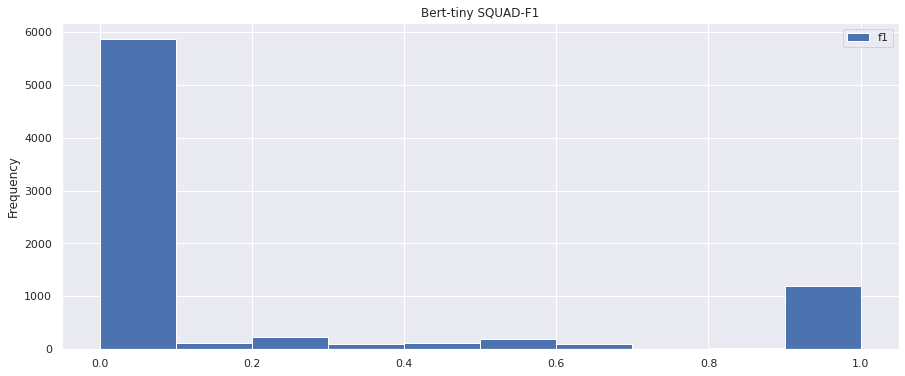

In [ ]:
all_results['bert-tiny'].plot.hist(title="Bert-tiny SQUAD-F1")

#### DistilRoberta

In [ ]:
all_results['distilroberta'].sort_values(['f1','source']).groupby('source').head(5)

,source,questions,pred,true_label,f1
38,cnn,What did he do?,he was a cop,Actor,0.0
41,cnn,Anything recent?,Yes,No,0.0
45,cnn,What parts did he usually get?,"""Police""",cops or gangsters,0.0
47,cnn,Which one?,Lawrence O'Neal,"""Law & Order""",0.0
49,cnn,Did he have a beater for a car?,yes,No,0.0
211,gutenberg,Did he have red hair?,Yes,No,0.0
213,gutenberg,What coast did the Ariel work her way up leisu...,Malaitaita,Malaita,0.0
214,gutenberg,Who argued to Villa that he must have a name?,Harding,Harley Kennan,0.0
215,gutenberg,Who began to tease Harley?,Her husband,Villa,0.0
218,gutenberg,Who was the husband she retorted something to?,Villa,Harley Kennan,0.0


<AxesSubplot:title={'center':'Distilroberta SQUAD-F1'}, ylabel='Frequency'>

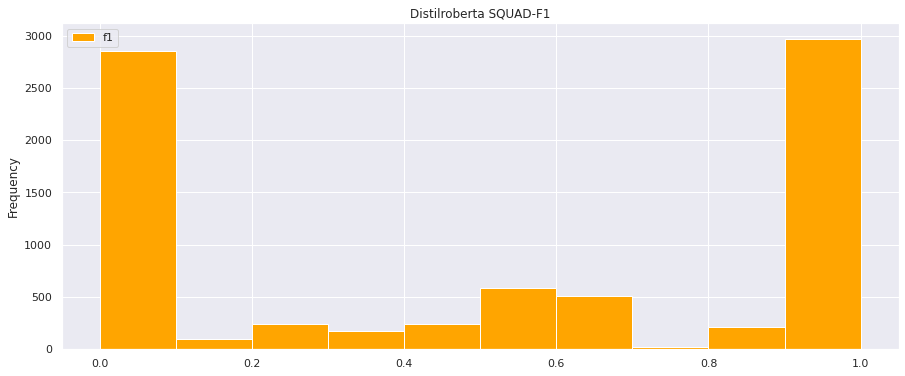

In [ ]:
all_results['distilroberta'].plot.hist(title="Distilroberta SQUAD-F1",color='orange')